In [1]:
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch CUDA version: {torch.version.cuda}")

from torch import nn
from torch.utils.data import DataLoader
import torch.cuda.nvtx as nvtx
from torchvision import datasets
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
import os
from torch.utils.cpp_extension import load_inline, load
torch.utils.cpp_extension.CUDA_HOME = '/usr/local/cuda-13.0'
print(f"torch.utils.cpp_extension.CUDA_HOME reports: {torch.utils.cpp_extension.CUDA_HOME}")

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(6910)

# Define the CUDA kernel and C++ wrapper
cuda_source = '''
__global__ void square_matrix_kernel(const float* matrix, float* result, int width, int height) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < height && col < width) {
        int idx = row * width + col;
        result[idx] = matrix[idx] * matrix[idx];
    }
}

torch::Tensor square_matrix(torch::Tensor matrix) {
    const auto height = matrix.size(0);
    const auto width = matrix.size(1);

    auto result = torch::empty_like(matrix);

    dim3 threads_per_block(16, 16);
    dim3 number_of_blocks((width + threads_per_block.x - 1) / threads_per_block.x,
                          (height + threads_per_block.y - 1) / threads_per_block.y);

    square_matrix_kernel<<<number_of_blocks, threads_per_block>>>(
        matrix.data_ptr<float>(), result.data_ptr<float>(), width, height);

    return result;
}
'''

cpp_source = "torch::Tensor square_matrix(torch::Tensor matrix);"

# Load the CUDA kernel as a PyTorch extension
square_matrix_extension = load_inline(
    name='square_matrix_extension',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['square_matrix'],
    with_cuda=True,
    extra_cuda_cflags=["-O3"],
    build_directory='./load_inline_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

a = torch.tensor([[1., 2., 3.], [4., 5., 6.]], device='cuda')
print(square_matrix_extension.square_matrix(a))

PyTorch CUDA available: True
PyTorch CUDA version: 13.0
torch.utils.cpp_extension.CUDA_HOME reports: /usr/local/cuda-13.0
Using cuda device
tensor([[ 1.,  4.,  9.],
        [16., 25., 36.]], device='cuda:0')


In [2]:
a = torch.rand(1000, 1000, device='cuda')
b = square_matrix_extension.square_matrix(a)
a, b, b.shape

(tensor([[0.6992, 0.4385, 0.8480,  ..., 0.6971, 0.4528, 0.4793],
         [0.1134, 0.7883, 0.2468,  ..., 0.0528, 0.4670, 0.2551],
         [0.5982, 0.4657, 0.0072,  ..., 0.6666, 0.3602, 0.4647],
         ...,
         [0.8408, 0.5899, 0.4801,  ..., 0.5806, 0.0114, 0.8757],
         [0.2805, 0.5004, 0.3686,  ..., 0.3183, 0.9848, 0.1388],
         [0.0013, 0.3699, 0.1293,  ..., 0.4128, 0.9574, 0.9697]],
        device='cuda:0'),
 tensor([[4.8884e-01, 1.9230e-01, 7.1911e-01,  ..., 4.8589e-01, 2.0500e-01,
          2.2973e-01],
         [1.2849e-02, 6.2143e-01, 6.0922e-02,  ..., 2.7873e-03, 2.1811e-01,
          6.5094e-02],
         [3.5780e-01, 2.1691e-01, 5.2073e-05,  ..., 4.4441e-01, 1.2971e-01,
          2.1593e-01],
         ...,
         [7.0698e-01, 3.4801e-01, 2.3049e-01,  ..., 3.3714e-01, 1.3053e-04,
          7.6686e-01],
         [7.8694e-02, 2.5045e-01, 1.3586e-01,  ..., 1.0132e-01, 9.6976e-01,
          1.9273e-02],
         [1.6233e-06, 1.3683e-01, 1.6725e-02,  ..., 1.7041e-

In [ ]:
cuda_source = '''
#include <curand.h>

__global__ void de_crossover_kernel(int NP, float CR, float F, int best_model, float* d_ptr, float* d_out_ptr, int size, float* d_all_agent_ids, float* d_Rs, float* d_ris, int layer_idx, int num_layers) {
	int idx = blockIdx.x * blockDim.x + threadIdx.x;

	if (idx < NP * size) {
		int id = idx / size; // candidate id
		int agent_ids[3]{d_all_agent_ids[id * 3 + 0] * NP, d_all_agent_ids[id * 3 + 1] * NP, d_all_agent_ids[id * 3 + 2] * NP};
		//printf("id: %d, best model: %d, agent 0: %d, agent 1: %d\\n", id, best_model, agent_ids[0], agent_ids[1]);
		int R = d_Rs[id] * num_layers;
		float ri = d_ris[layer_idx * NP + id];
  
		// printf("id %d, agent_ids [%d, %d, %d], R %d, (d_Rs %.3f, num_layers %d), ri %.3f\\n", id, agent_ids[0], agent_ids[1], agent_ids[2], R, d_Rs[id], num_layers, ri);

		if (ri < CR || layer_idx == R) {
			d_out_ptr[idx] = d_ptr[idx] + F * (d_ptr[best_model * size + idx % size] - d_ptr[idx]) + F * (d_ptr[agent_ids[0] * size + idx % size] - d_ptr[agent_ids[1] * size + idx % size]);
			//printf("crossover layer %d of id %d with agent0 %d and agent1 %d using ri %f and R %d \\n id d_ptr[%d] = %f best_model d_ptr[%d] = %f agent0 d_ptr[%d] = %f agent1 d_ptr[%d] = %f\\n", layer_idx, id, agent_ids[0], agent_ids[1], ri, R,
			//	idx, d_ptr[idx], best_model * size + idx % size, d_ptr[best_model * size + idx % size], agent_ids[0] * size + idx % size, d_ptr[agent_ids[0] * size + idx % size], agent_ids[1] * size + idx % size, d_ptr[agent_ids[1] * size + idx % size]);
		}
	}
}

curandGenerator_t gen;
void curand_init() {
	curandCreateGenerator(&gen, CURAND_RNG_PSEUDO_DEFAULT);
	curandSetPseudoRandomGeneratorSeed(gen, 5691ULL);
	std::cout << "initializing curand" << std::endl;
}

int N = 64;
std::vector<std::vector<torch::Tensor>> de_crossover_cuda(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, int64_t best_model) {
	int num_layers = layers.size();
	std::vector<float*> layer_ptrs(num_layers), bias_ptrs(num_layers);
 	std::vector<float*> out_layer_ptrs(num_layers), out_bias_ptrs(num_layers);
	std::vector<torch::Tensor> out_layers(num_layers), out_biases(num_layers);

	float* d_all_agent_ids;
	float* d_Rs;
	float* d_ris;
	int num_agents = NP * 3, num_Rs = NP, num_ris = num_layers * NP;
	cudaMalloc(&d_all_agent_ids, num_agents * sizeof(float));
	cudaMalloc(&d_Rs, num_Rs * sizeof(float));
	cudaMalloc(&d_ris, num_ris * sizeof(float));

	curandGenerateUniform(gen, d_all_agent_ids, num_agents);
	curandGenerateUniform(gen, d_Rs, num_Rs);
	curandGenerateUniform(gen, d_ris, num_ris);
	//std::cout << "num_layers " << num_layers << std::endl;

	for (int i = 0; i < num_layers; i++) {
     	//printf("layer %d:\\n", i);
		
		torch::Tensor layer_contig = layers[i].contiguous();
		torch::Tensor bias_contig = biases[i].contiguous();
		layer_ptrs[i] = layer_contig.data_ptr<float>();
		bias_ptrs[i] = bias_contig.data_ptr<float>();

		//out_layers[i] = torch::empty(layer_contig.sizes(), layer_contig.options());
		//out_biases[i] = torch::empty(bias_contig.sizes(), bias_contig.options());
		out_layers[i] = torch::clone(layer_contig);
		out_biases[i] = torch::clone(bias_contig);
		out_layer_ptrs[i] = out_layers[i].data_ptr<float>();
		out_bias_ptrs[i] = out_biases[i].data_ptr<float>();

		de_crossover_kernel<<<max(1l, (layer_contig.numel() + N - 1) / N), N>>>(NP, CR, F, best_model, layer_ptrs[i], out_layer_ptrs[i], layer_contig.numel() / NP, d_all_agent_ids, d_Rs, d_ris, i, num_layers);
		de_crossover_kernel<<<max(1l, (bias_contig.numel() + N - 1) / N), N>>>(NP, CR, F, best_model, bias_ptrs[i], out_bias_ptrs[i], bias_contig.numel() / NP, d_all_agent_ids, d_Rs, d_ris, i, num_layers);
		
		cudaDeviceSynchronize();
		//std::cout << "layer " << i << " has " << layer_contig.numel() / NP << " parameters" << std::endl;
		//std::cout << "bias  " << i << " has " << bias_contig.numel() / NP  << " parameters" << std::endl;
	}
   	cudaDeviceSynchronize();
	cudaFree(d_all_agent_ids);
	cudaFree(d_Rs);
	cudaFree(d_ris);
 	//std::cout << "crossover finished" << std::endl;
 	return {out_layers, out_biases};
}
'''

cpp_source = '''
void curand_init();
std::vector<std::vector<torch::Tensor>> de_crossover_cuda(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, int64_t best_model);
'''

# Load the CUDA kernel as a PyTorch extension
diff_evo = load_inline(
    name='diff_evo',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['de_crossover_cuda', 'curand_init'],
    with_cuda=True,
    extra_cuda_cflags=["-O3", "-lcurand"],
    build_directory='./diff_evo_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

diff_evo.curand_init()

initializing curand


In [16]:
NP = 5
lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 2, 2), requires_grad=False).to(device, non_blocking=True))
layers = [lin1s, lin2s]
#print(layers)

bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 2, 1), requires_grad=False).to(device, non_blocking=True))
biases = [bias1, bias2]

lst = diff_evo.de_crossover_cuda(layers, biases, NP, 0.9, 0.8, 0)
#print(lst[0])

In [10]:
NP = 44
lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
layers = [lin1s, lin2s, lin3s, lin4s]

bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
biases = [bias1, bias2, bias3, bias4]

diff_evo.de_crossover_cuda(layers, biases, NP, 0.9, 0.8, 0)

[[tensor([[[-0.6082],
           [ 2.0052],
           [ 0.3467],
           [-1.8388]],
  
          [[ 1.0884],
           [ 0.6889],
           [ 0.6104],
           [-1.7391]],
  
          [[-0.2937],
           [ 0.0623],
           [ 1.0782],
           [-1.9760]],
  
          [[-1.7983],
           [-1.2639],
           [ 0.6570],
           [ 0.1768]],
  
          [[-0.6081],
           [ 0.9087],
           [-0.0274],
           [-0.6338]],
  
          [[-1.4551],
           [ 0.0433],
           [ 1.2038],
           [-0.5459]],
  
          [[-1.3669],
           [-0.3040],
           [ 1.2240],
           [-1.3514]],
  
          [[ 0.9138],
           [ 0.7699],
           [ 0.1805],
           [-2.1558]],
  
          [[-0.6371],
           [-0.0898],
           [-0.0426],
           [-1.6440]],
  
          [[-0.4049],
           [ 0.6532],
           [ 0.9608],
           [-0.7031]],
  
          [[ 0.9811],
           [ 0.2718],
           [ 1.3568],
           [ 0

In [17]:
theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])

batch_size = 400000

class DE_NN(nn.Module):
    def __init__(self, NP, CR, F):
        super(DE_NN, self).__init__()
        lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
        lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
        lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
        self.layers = [lin1s, lin2s, lin3s, lin4s]
        bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
        bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
        self.biases = [bias1, bias2, bias3, bias4]
        self.NP = NP
        self.CR = CR
        self.F = F
        self.min_l = torch.tensor(float('inf'))
        self.best_model = 0
    def forward_all(self, X, layers, biases):
        # This is just bmm???
        for i in range(len(layers) - 1):
            X = torch.relu(torch.einsum('lik,lkj->lij', layers[i], X) + biases[i])
        X = torch.einsum('lik,lkj->lij', layers[len(layers) - 1], X) + biases[len(layers) - 1]
        return X
    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.relu(torch.matmul(self.layers[i][self.best_model], X) + self.biases[i][self.best_model])
        return torch.matmul(self.layers[len(self.layers) - 1][self.best_model], X) + self.biases[len(self.layers) - 1][self.best_model]
    def step(self, X, Y, L, type='param'): # forward pass with candidate i
        nvtx.range_push("forward_1")
        fx = L(self.forward_all(X, self.layers, self.biases), Y).mean(dim = 2)
        nvtx.range_pop()
        nvtx.range_push(f"copy layers")
        #y_layers = [self.layers[i].detach().clone() for i in range(len(self.layers))]
        #y_biases = [self.biases[i].detach().clone() for i in range(len(self.layers))]
        nvtx.range_pop()
        
        y_layers, y_biases = diff_evo.de_crossover_cuda(self.layers, self.biases, self.NP, self.CR, self.F, 0)
        


        nvtx.range_push("forward_2")
        fy = L(self.forward_all(X, y_layers, y_biases), Y).mean(dim = 2)
        nvtx.range_pop()

        for id in range(self.NP):
            nvtx.range_push(f"updating model {id}")
            if fy[id] <= fx[id]:
                for i in range(len(self.layers)):
                    self.layers[i][id].copy_(y_layers[i][id])
                    self.biases[i][id].copy_(y_biases[i][id])
                fx[id] = fy[id]
            if fx[id] < self.min_l:
                self.best_model = id
                self.min_l = fx[id]
            nvtx.range_pop()
        # what if we update layers on the CPU, the transfer it to the GPU so we dont incur costs for launching small kernels
        # what if we iteratively compute the forward loss instead of waiting for everything to finish just to hide latency?

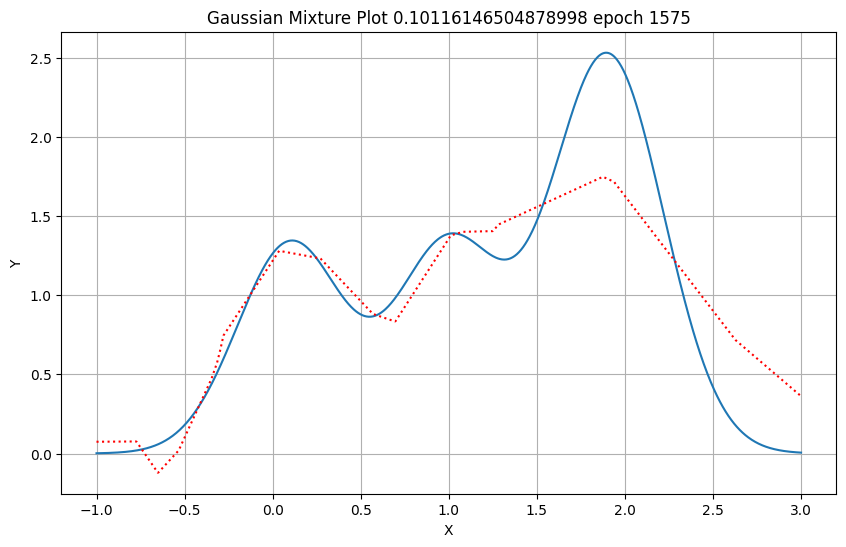

In [ ]:
epochs = 2000

NP = 44
CR = 0.9
F = 0.8
X = torch.rand(1, batch_size).to(device) * 5 - 1
Y = gaussian_mixture(X).to(device)

print(X.shape, Y.shape)
X = X.unsqueeze(0).expand(NP, 1, batch_size)
Y = Y.unsqueeze(0).expand(NP, 1, batch_size)
print(X.shape, Y.shape)

model = DE_NN(NP, CR, F).to(device) 
model = torch.compile(model, mode='default')
L = nn.MSELoss(reduction='none')

Y_pred = model.forward_all(X, model.layers, model.biases)
print(Y_pred.shape)


for e in range(epochs):
    model.step(X, Y, L, 'block')
    if e % 5 == 0:
        with torch.no_grad():
            test_X = torch.linspace(-1, 3, 1000).unsqueeze(0)
            test_Y = gaussian_mixture(test_X)
            model_Y = model(test_X.to(device)).cpu()
            # Clear the previous output before plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(test_X.numpy()[0], test_Y.numpy()[0], label='Gaussian Mixture')
            plt.plot(test_X.numpy()[0], model_Y.numpy()[0], label='Predictions', color='red', linestyle='dotted')
            plt.title(f'Gaussian Mixture Plot {model.min_l.item()} epoch {e}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()